# Home Credit Default Prediction Models

### About Home Credit
Home Credit is a non-banking financial institution, founded in 1997 in the Czech Republic. 
* The company operates in 14 countries (including United States, Russia, Kazahstan, Belarus, China, India) and focuses on lending primarily to people with little or no credit history which will either not obtain loans or became victims of untrustworthly lenders. Home Credit group has over 29 million customers, total assests of 21 billions Euro, over 160 millions loans.
* It uses of a variety of alternative data - including telco and transactional information - to predict their clients' repayment abilities.

### About the data
https://www.kaggle.com/c/home-credit-default-risk

### EDA and Basic Modeling by Kun Gu
https://github.com/gukun770/Home-Credit

### Team @ Galvanize
* Liyou Zhang
* Iniyavan Sathiamurthi - https://github.com/inistar
* Mar Carpanelli - https://github.com/mcarpanelli

## 0. Setup

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scs

%matplotlib inline
plt.style.use('ggplot') # overall 'ggplot' style

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
col_description = pd.read_csv('HomeCredit_columns_description.csv',
                              index_col=0,encoding='cp1252')

def col_name(name, col_description=col_description):
    values = col_description[col_description['Row'] == name]['Description'].values
    print(name + ': \n')
    for i in values:
        print (i+'\n')
    table = col_description[col_description['Row'] == name]['Table'].values
    print('Table: {}\n'.format(table))

In [3]:
application_train = pd.read_csv('application_train.csv') 
application_test = pd.read_csv('application_test.csv')

In [4]:
#application_train.corr().abs()>0.5

## 1. Some more EDA

#### Unbalanced Classes

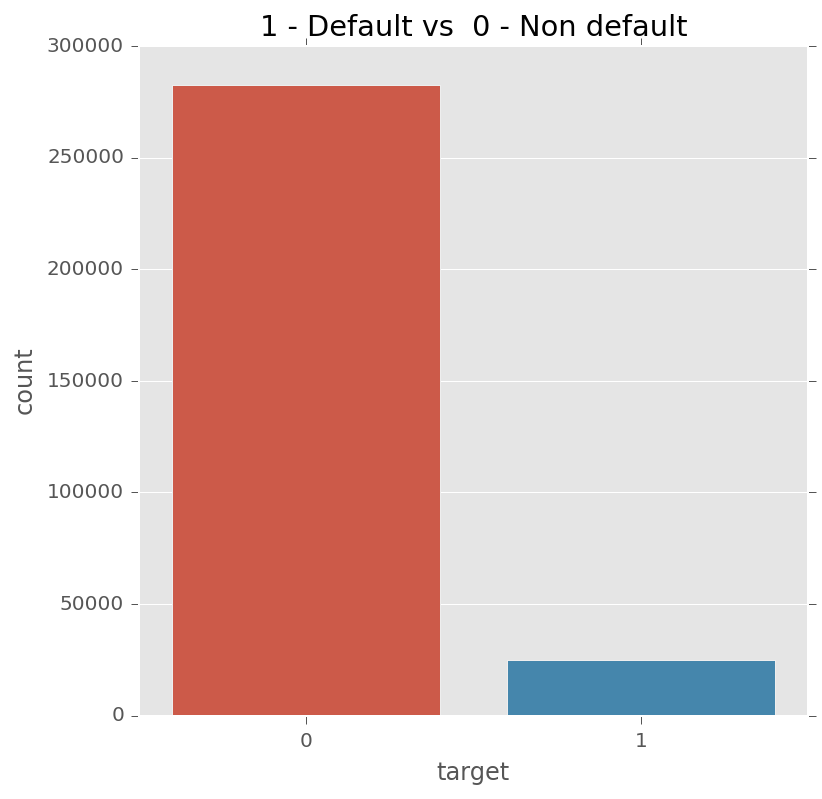

In [5]:
target = application_train["TARGET"].value_counts()
df = pd.DataFrame({'target': target.index,
                   'count': target.values
                  })
plt.figure(figsize = (6,6))
plt.title('1 - Default vs  0 - Non default')
sns.barplot(x = 'target', y="count", data=df);

#### Income

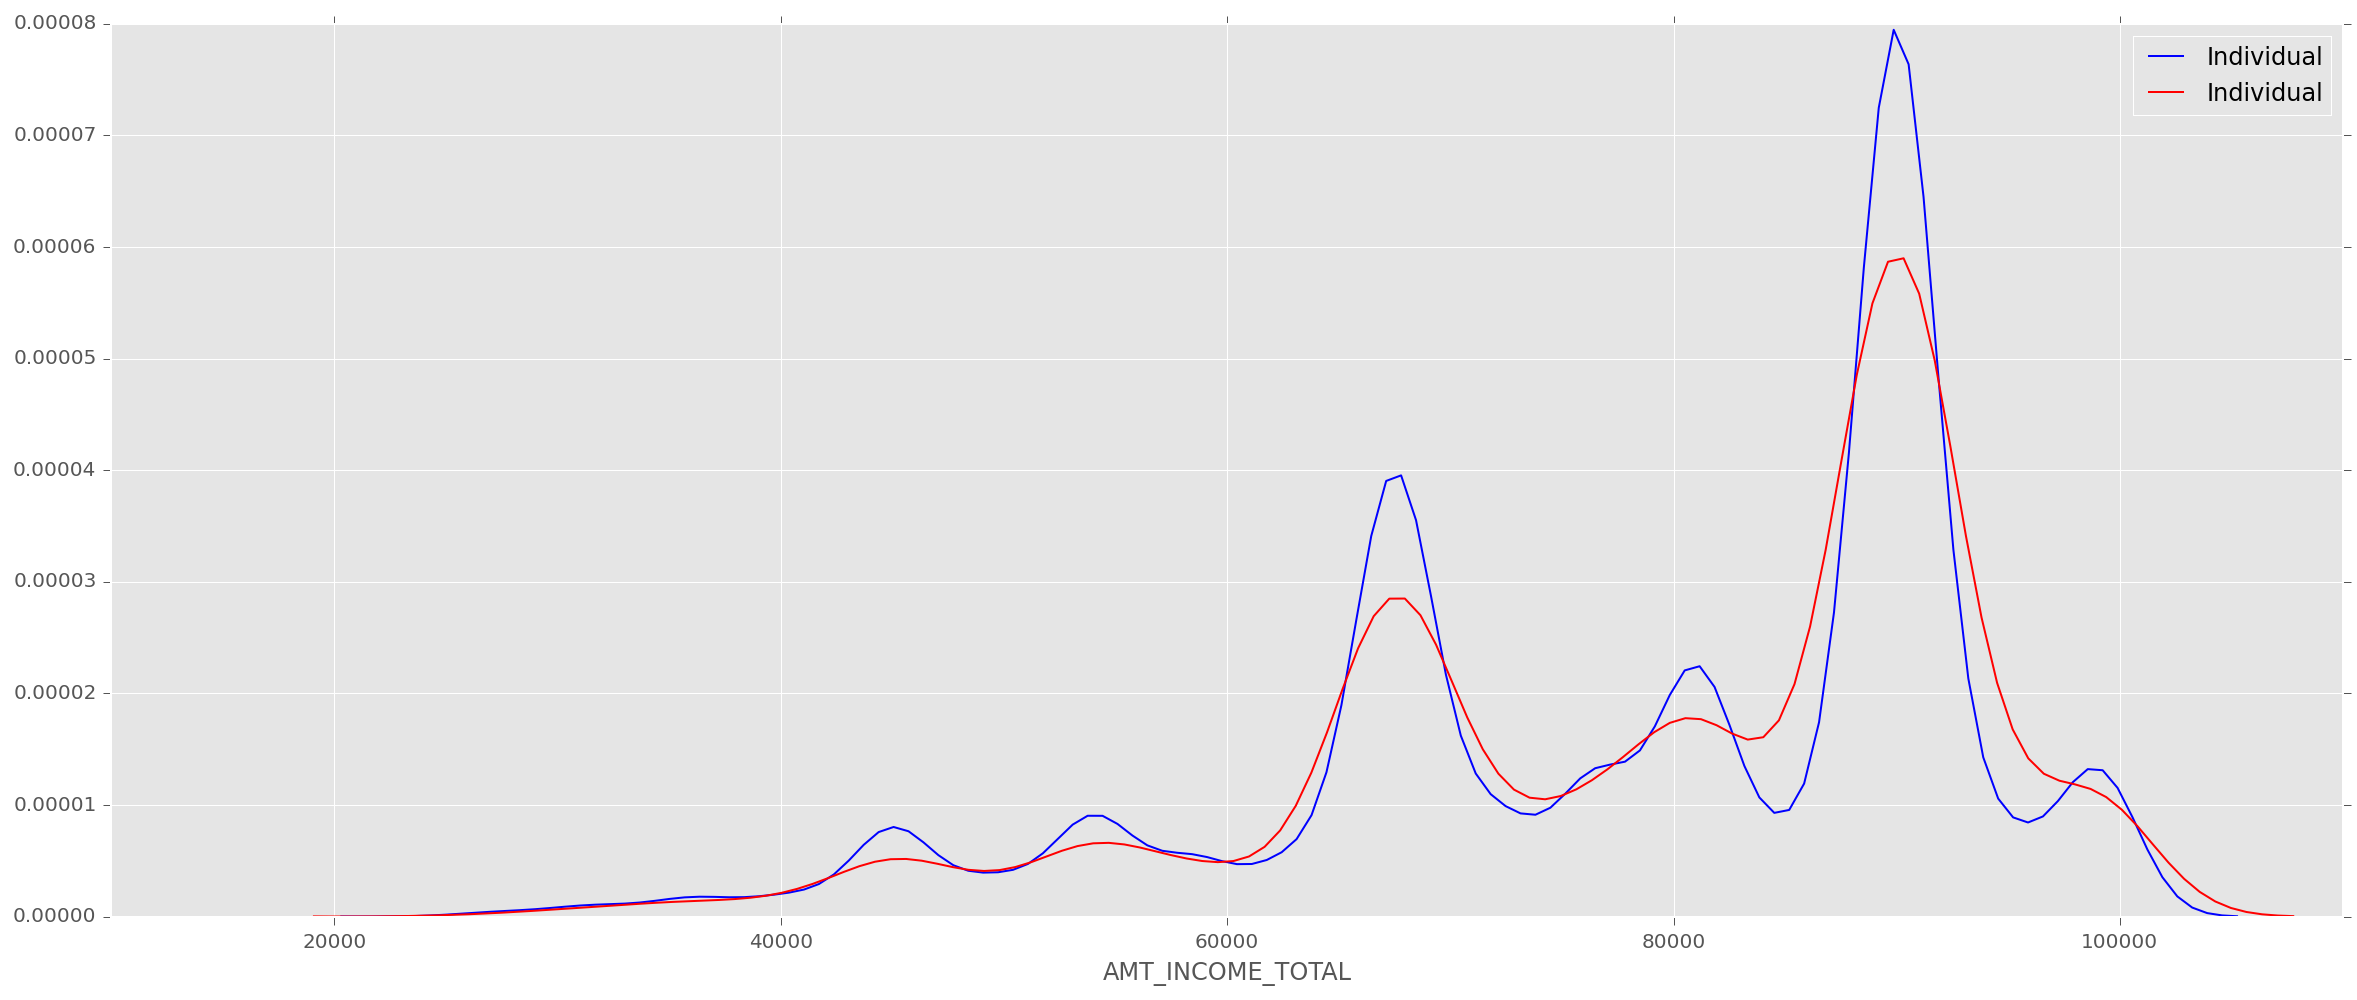

In [6]:
plt.figure(figsize=(20,8))
sns.distplot(application_train['AMT_INCOME_TOTAL'], hist=False, color='blue', label = 'Individual', kde_kws={'clip': (0, 100000)})
sns.distplot(application_test['AMT_INCOME_TOTAL'], hist=False, color='red', label = 'Individual', kde_kws={'clip': (0, 100000)})

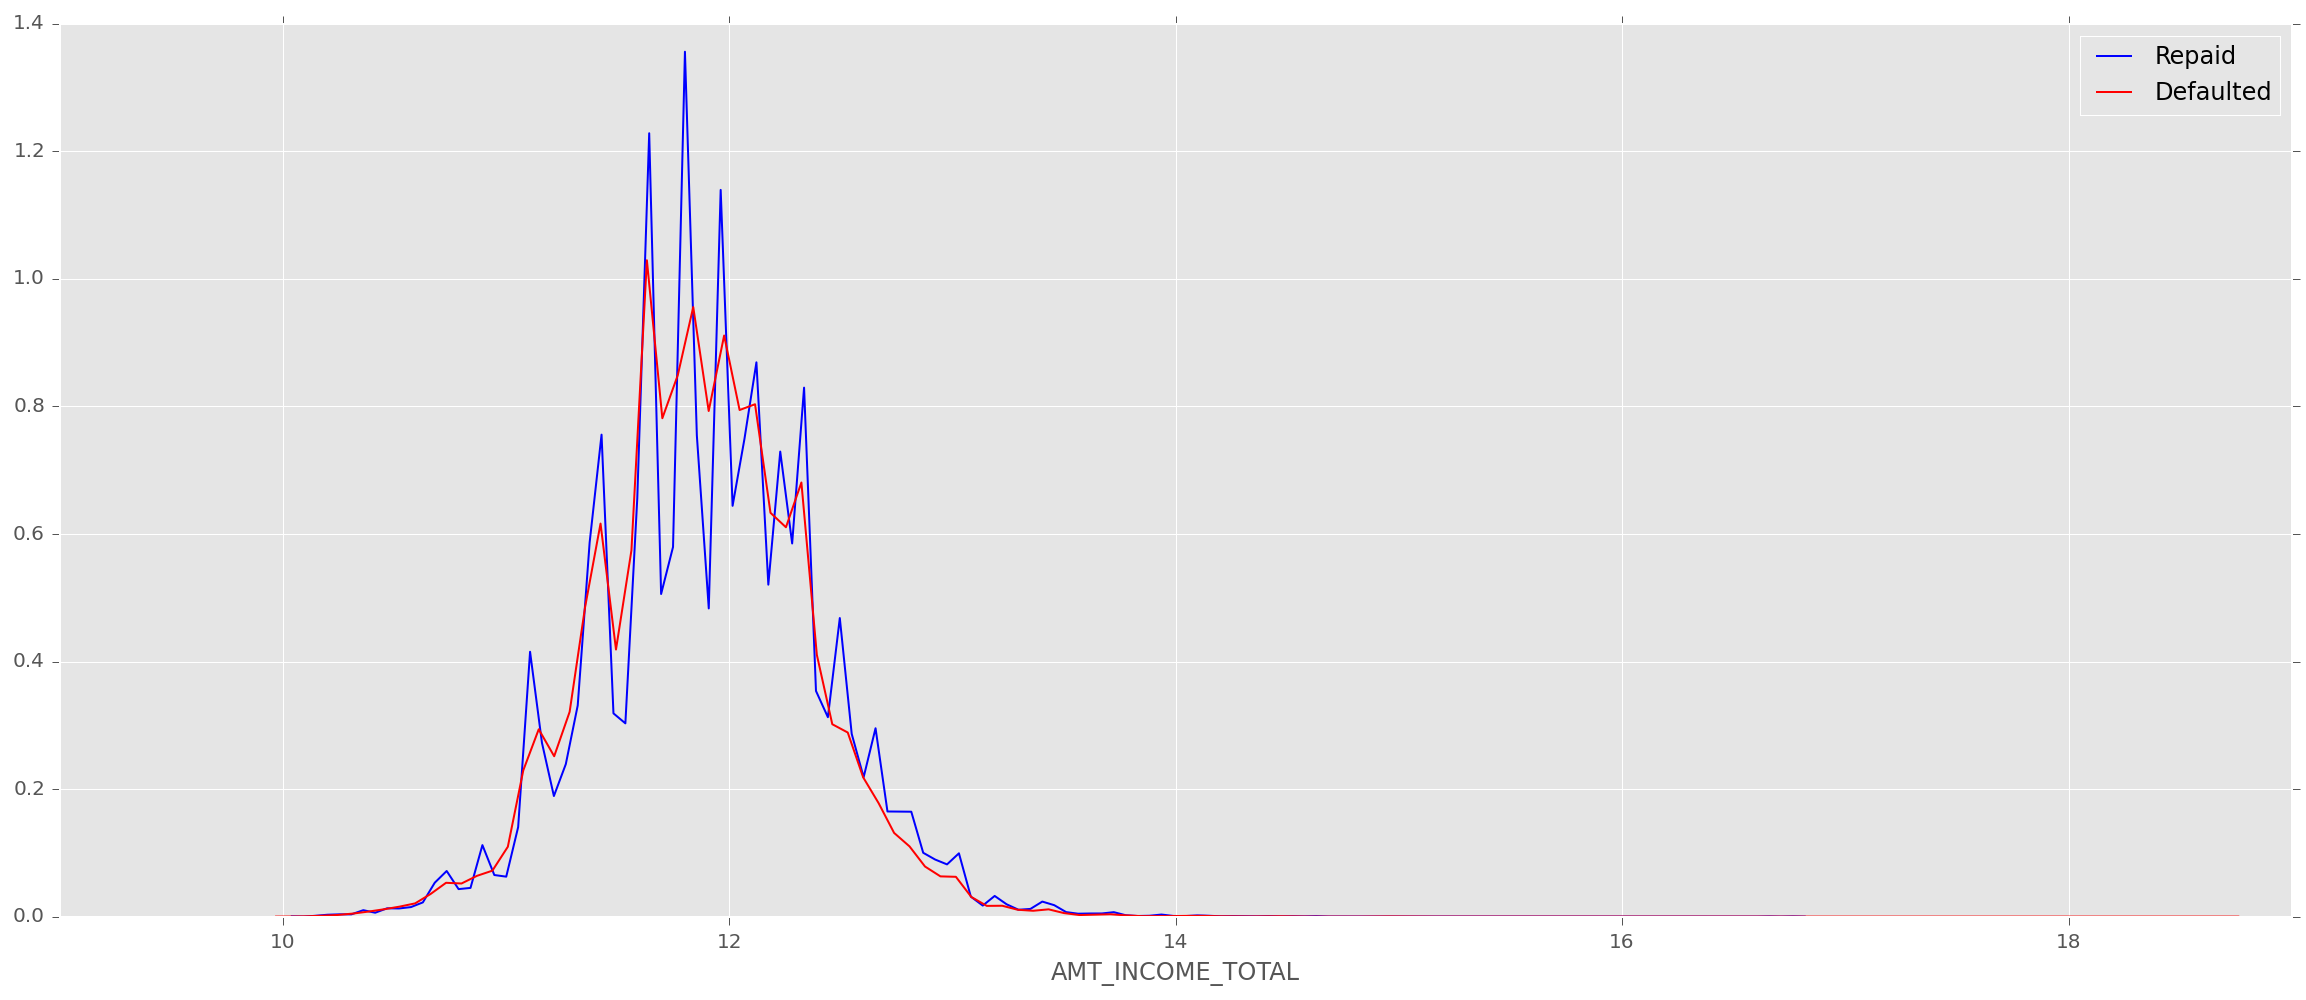

In [7]:
plt.figure(figsize=(20,8))
sns.distplot(np.log(application_train['AMT_INCOME_TOTAL'][application_train["TARGET"]==0]), hist=False, color='blue', label = 'Repaid')#, kde_kws={'clip': (0, 100000)})
sns.distplot(np.log(application_train['AMT_INCOME_TOTAL'][application_train["TARGET"]==1]), hist=False, color='red', label = 'Defaulted')#, kde_kws={'clip': (0, 100000)})

In [8]:
application_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.000000,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.000000,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.000000,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.500000,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.000000,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.000290,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.000000,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.000000,-2760.000000,-1213.000000,-289.000000,3.652430e+05


In [9]:
# Missings
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1,
                                            keys=['Total', 'Percent'])
missing_application_train_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


## 2. Feature Engineering

In [10]:
sets = [application_train, application_test]

## Borrower characteristics

In [11]:
for i in sets:
    i["AGE"] = application_train["DAYS_BIRTH"]/-365
    i["AGESQ"] = application_train["AGE"]**2

In [12]:
for i in sets:
    i_dummies=pd.get_dummies(i[['CODE_GENDER', 'NAME_EDUCATION_TYPE',
                               'NAME_FAMILY_STATUS', 'NAME_TYPE_SUITE', 
                                'NAME_INCOME_TYPE']],drop_first=True)
    i[i_dummies.columns]=i_dummies
    #print(i_dummies.columns)

## Employment

In [13]:
for i in sets:
    i_dummies=pd.get_dummies(i[['OCCUPATION_TYPE']],drop_first=True)
    i[i_dummies.columns]=i_dummies
    #print(i_dummies.columns)

In [14]:
for i in sets:
    i['employed'] = i['DAYS_EMPLOYED']!=365243 *1
    i['YEARS_EMPLOYED'] = i['DAYS_EMPLOYED']/-365
    i["INCOME_LOG"] = np.log(i["AMT_INCOME_TOTAL"])
    i['employed_years']=i['employed']* i['YEARS_EMPLOYED']

In [15]:
# application_train[['OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'SK_ID_CURR']].groupby(['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE']).count()

## Assets

In [16]:
for i in sets:
    i_dummies=pd.get_dummies(i[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                            'NAME_HOUSING_TYPE']],drop_first=True)
    i[i_dummies.columns]=i_dummies
    i_dummies.columns

In [17]:
for i in sets:
    i['FLAG_OWN_CAR_CAR_AGE']=i['FLAG_OWN_CAR_Y']*i['OWN_CAR_AGE']

## Credit

In [18]:
for i in sets:
    i_dummies=pd.get_dummies(i[['NAME_CONTRACT_TYPE']],drop_first=True)
    i[i_dummies.columns]=i_dummies
    i_dummies.columns

In [19]:
for i in sets:
    i["AMT_CREDIT_LOG"] = np.log(i["AMT_CREDIT"]) # this is the amount of the loan
    i["AMT_GOODS_PRICE_LOG"] =np.log(i['AMT_GOODS_PRICE']) # FOR CONS LOANS-- half million usd???
    i["AMT_ANNUITY_LOG"] =np.log(i['AMT_ANNUITY'])
    i['CREDIT_INCOME'] = i["AMT_CREDIT"]/i["AMT_INCOME_TOTAL"]
    i['ANNUITY_INCOME'] = i['AMT_ANNUITY']/i["AMT_INCOME_TOTAL"]

In [20]:
docs =  ['FLAG_DOCUMENT_2',  'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

for i in sets:
    i['DOCS'] = 0
    for d in docs:
        application_train['DOCS'] += application_train[d]
    
# application_train['DOCS']

In [21]:
application_train.head().T

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500,270000,67500,135000,121500
AMT_CREDIT,406598,1.2935e+06,135000,312682,513000
AMT_ANNUITY,24700.5,35698.5,6750,29686.5,21865.5


In [22]:
application_test.head().T

,0,1,2,3,4
SK_ID_CURR,100001,100005,100013,100028,100038
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Cash loans,Cash loans,Cash loans
CODE_GENDER,F,M,M,F,M
FLAG_OWN_CAR,N,N,Y,N,Y
FLAG_OWN_REALTY,Y,Y,Y,Y,N
CNT_CHILDREN,0,0,0,2,1
AMT_INCOME_TOTAL,135000,99000,202500,315000,180000
AMT_CREDIT,568800,222768,663264,1.575e+06,625500
AMT_ANNUITY,20560.5,17370,69777,49018.5,32067
AMT_GOODS_PRICE,450000,180000,630000,1.575e+06,625500


## 3. Modeling

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_curve
from sklearn.preprocessing import PolynomialFeatures, Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report

In [24]:
# for i in sorted(application_train.columns):
#     print(i)

#### Train

In [25]:
df_train_1 = application_train[['TARGET','AGE', 'AGESQ','REGION_RATING_CLIENT_W_CITY',
                                'DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                                'CODE_GENDER_M', 'NAME_EDUCATION_TYPE_Higher education',
                                'NAME_EDUCATION_TYPE_Incomplete higher',
                                'NAME_EDUCATION_TYPE_Lower secondary',
                                'NAME_EDUCATION_TYPE_Secondary / secondary special',
                                'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
                                'NAME_FAMILY_STATUS_Single / not married', 
                                'NAME_FAMILY_STATUS_Widow', 'NAME_TYPE_SUITE_Family',
                                'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A',
                                'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner',
                                'NAME_TYPE_SUITE_Unaccompanied',
                                'NAME_INCOME_TYPE_Commercial associate',
                                'NAME_INCOME_TYPE_Pensioner',
                                'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
                                'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working',
                                'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
                                'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
                                'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_High skill tech staff',
                                'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Laborers',
                                'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
                                'OCCUPATION_TYPE_Medicine staff',
                                'OCCUPATION_TYPE_Private service staff',
                                'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
                                'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff',
                                'OCCUPATION_TYPE_Waiters/barmen staff',
                                'employed', 'employed_years',
                                'INCOME_LOG',
                                'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y',
                                'NAME_HOUSING_TYPE_House / apartment',
                                'NAME_HOUSING_TYPE_Municipal apartment',
                                'NAME_HOUSING_TYPE_Office apartment',
                                'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
                                'FLAG_OWN_CAR_CAR_AGE', 'NAME_CONTRACT_TYPE_Revolving loans',
                                'AMT_CREDIT_LOG', 'AMT_GOODS_PRICE_LOG', 'AMT_ANNUITY_LOG',
                                'CREDIT_INCOME', 'ANNUITY_INCOME', 'DOCS']]

In [26]:
X_train = df_train_1.drop('TARGET',axis=1).values
y_train = df_train_1['TARGET'].values

#### Test

In [27]:
X_test = application_test[['AGE', 'AGESQ','REGION_RATING_CLIENT_W_CITY',
                                'DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',
                                'CODE_GENDER_M', 'NAME_EDUCATION_TYPE_Higher education',
                                'NAME_EDUCATION_TYPE_Incomplete higher',
                                'NAME_EDUCATION_TYPE_Lower secondary',
                                'NAME_EDUCATION_TYPE_Secondary / secondary special',
                                'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated',
                                'NAME_FAMILY_STATUS_Single / not married',
                                'NAME_FAMILY_STATUS_Widow', 'NAME_TYPE_SUITE_Family',
                                'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A',
                                'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner',
                                'NAME_TYPE_SUITE_Unaccompanied',
                                'NAME_INCOME_TYPE_Commercial associate',
                                'NAME_INCOME_TYPE_Pensioner',
                                'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
                                'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working',
                                'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
                                'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
                                'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_High skill tech staff',
                                'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Laborers',
                                'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
                                'OCCUPATION_TYPE_Medicine staff',
                                'OCCUPATION_TYPE_Private service staff',
                                'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
                                'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff',
                                'OCCUPATION_TYPE_Waiters/barmen staff',
                                'employed', 'employed_years',
                                'INCOME_LOG',
                                'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y',
                                'NAME_HOUSING_TYPE_House / apartment',
                                'NAME_HOUSING_TYPE_Municipal apartment',
                                'NAME_HOUSING_TYPE_Office apartment',
                                'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
                                'FLAG_OWN_CAR_CAR_AGE', 'NAME_CONTRACT_TYPE_Revolving loans',
                                'AMT_CREDIT_LOG', 'AMT_GOODS_PRICE_LOG', 'AMT_ANNUITY_LOG',
                                'CREDIT_INCOME', 'ANNUITY_INCOME', 'DOCS']]

In [28]:
X_test = X_test.values

### Logistic

In [29]:
imp = Imputer(strategy='median') 
imp.fit(X_train) 

# transform the test & train data
X_train=imp.transform(X_train)
X_test=imp.transform(X_test)


scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (307511, 63)
Testing data shape:  (48744, 63)


In [30]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train,y_train)
p = model.predict_proba(X_train)[:,1]
probabilities = model.predict_proba(X_test)[:,1]

In [31]:
# classification_report(y_train,p)

In [32]:
# from statsmodels.discrete.discrete_model import Logit

In [33]:
# model_sts = Logit(y_train,X_train)
# model_sts.fit(y_train,X_train).summary()

## 4. Submission 

In [34]:
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = probabilities
submit.head()

//anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.425000
1,100005,0.769057
2,100013,0.318876
3,100028,0.418669
4,100038,0.579153


In [35]:
submit.to_csv('logistic_2018-06-23.csv', index = False)